# Predicciones Valencia verano

## MBIT School

# a) Importamos libreías y datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
df = pd.read_csv('valencia_clean.csv')
co = pd.read_csv('C:/Users/34610/Desktop/TFM/CO2/valencia_co2.csv')

Visualización de los DataFrames

In [3]:
# df.head()
# df.info()
# co.head()
# co.info()

Observamos que 'df' y 'co' no tienen el mismo inicio en el tiempo. Lo corregiremos después de resetear el índice.

In [4]:
# Pasamos a formato fecha la columna 'fecha'
df['fecha'] = pd.to_datetime(df['fecha'])
co['fecha'] = pd.to_datetime(co['fecha'])

# Seleccionamos la columna 'fecha' como índice
df = df.set_index('fecha', drop = True)
co = co.set_index('fecha', drop = True)

Como los datos 'co' comienzan en 1958 pero los datos de 'df' empiezan en 1948 procedemos a eliminar los valores inferiores a 1948 del DataFame de Valencia

In [5]:
# Eliminamos las fechas posteriores a 1958 en 'df'
df = df[df.index > '1957-12-31']

In [6]:
# Cambiamos la temporalidad a anual mediante la media por año
co = co.resample('A').mean()

Para el estudio de las olas de calor de bemos centrarnos en los meses en los que se registran las máximas temperaturas. Por este motivo seleccionamos del índice los meses deseados para eltudio (junio, julio y agosto).

In [7]:
# Seleccionamos los meses de mayores temperaturas
df = df[df.index.month.isin([6, 7, 8])]

In [8]:
# Cambiamos la temporalidad a anual mediante la media por año
df = df.resample('A').mean()

In [9]:
# Unimos la columna 'co2' del DataFrame 'co' a DataFrame 'df'
df = df.join(co['co2'])

# b) Comprobación manual de las variables

In [10]:
# Correlación anual
df.corr()

,tmed,prec,tmin,tmax,sol,presMax,presMin,co2
tmed,1.000000,-0.144441,0.965731,0.962160,0.504084,-0.581771,-0.559646,0.792579
prec,-0.144441,1.000000,-0.139145,-0.139300,-0.304496,-0.048144,-0.031366,-0.033753
tmin,0.965731,-0.139145,1.000000,0.858474,0.431976,-0.655154,-0.638470,0.848288
tmax,0.962160,-0.139300,0.858474,1.000000,0.542663,-0.461809,-0.435688,0.675403
sol,0.504084,-0.304496,0.431976,0.542663,1.000000,-0.300854,-0.303370,0.511056
presMax,-0.581771,-0.048144,-0.655154,-0.461809,-0.300854,1.000000,0.994677,-0.801253
presMin,-0.559646,-0.031366,-0.638470,-0.435688,-0.303370,0.994677,1.000000,-0.794805
co2,0.792579,-0.033753,0.848288,0.675403,0.511056,-0.801253,-0.794805,1.000000


**Random forest para la selección de variables**

- Modelo con temporalidad anual.

In [11]:
# Importamos librería de RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

In [12]:
# Seleccionamos las variables para temporalidad anual
X = df.drop(columns = ['tmed', 'tmax', 'tmin'], axis = 1)
y = df['tmed']

In [13]:
# Entrenamos el modelo
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor()

In [14]:
# Guardamos variables explicativas
importancias = rf.feature_importances_
forest_importances = pd.Series(importancias, index=X.columns)

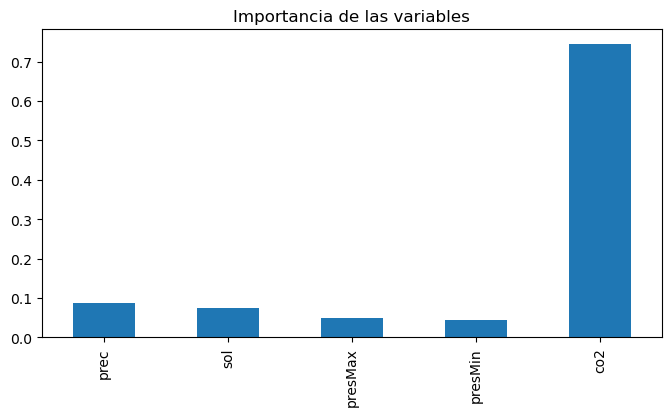

In [15]:
# Generamos el gráfico
forest_importances.plot.bar(figsize=(8, 4)).set_title('Importancia de las variables');

Comprobamos que la variable explicativa que mejor explica la variable objetivo en el largo plazo es, nuevamente, la variable 'co2'.

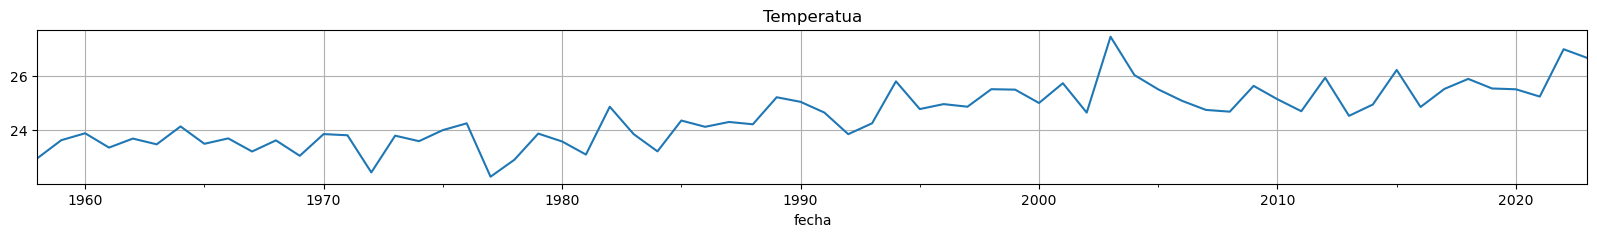

In [16]:
# Observamos la evolución de la variable a predecir 'tmed'
df['tmed'].plot(figsize = (20, 2))
plt.title('Temperatua')
plt.grid()
plt.show()

# c) Modelos de Regrsión

Los modelos de regresión sirven para analizar las relaciones entre las variables explicativas y la variable que queremos explicar, en nuestro caso las temeperaturas.

### c) I. Regresión Lineal

In [17]:
# Seleccionamos las variables
X = df[['co2']].values
y = df['tmed'].values

Dividimos nuestro DataFrame en un conjunto para entrenar y en optro para testear. Al reducir la muestra de los datos debido a la temporalidad elegida para la representación de los mismos utilizaremos el 80% de los datos para entrenar y el 30% restante para testear.

In [18]:
# Biblioteca para dividir en trin y test
from sklearn.model_selection import train_test_split

In [19]:
# Devidimos 'df' en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)
print(f'''Tamaño de los conjuntos de train y test:
- Train de X {X_train.shape}
- Test de X {X_test.shape}
- Train de y {y_train.shape}
- Test de y {y_test.shape}''')

Tamaño de los conjuntos de train y test:
- Train de X (46, 1)
- Test de X (20, 1)
- Train de y (46,)
- Test de y (20,)


In [20]:
# Biblioteca para la regresión lineal
from sklearn.linear_model import LinearRegression

# Biblioteca para medir el rendimietno de las regresiones
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
# Generamos el modelo de regresión lineal
regression_lineal = LinearRegression()
# Entrenamiento con datos de train
regression_lineal.fit(X_train, y_train)

LinearRegression()

***Evaluación de train y test***

In [22]:
# Evaluamos el rendimiento de train
y_train_predict = regression_lineal.predict(X_train)
rmse_l = mean_squared_error(y_train, y_train_predict, squared = False)
r2_l = r2_score(y_train, y_train_predict)

print(f'''Rendimiento del modelo para el conjunto de train
- R2: {r2_l}
- RMSE: {rmse_l}
''')

# Evaluamos el rendimiento de test
y_test_predict = regression_lineal.predict(X_test)
rmse_l = mean_squared_error(y_test, y_test_predict, squared = False)
r2_l = r2_score(y_test, y_test_predict)

print(f'''Rendimiento del modelo para el conjunto de train
- R2: {r2_l}
- RMSE: {rmse_l}
''')

Rendimiento del modelo para el conjunto de train
- R2: 0.6005416800080114
- RMSE: 0.6766027663752924

Rendimiento del modelo para el conjunto de train
- R2: 0.6824797583096394
- RMSE: 0.6002427396360619



El ***R2*** de ***train*** nos indica que el ***60.05%*** de nuestros datos se pueden explicar mediante el modelo de regresión lineal. En el conjunto de ***test*** baja esta capacidad de explicación al ***68.25%***. La discrepancia entre train y test puede venir por el número reducido de la muestra que tenemos. Al reducir los datos a anuales para captar mejor la correlación entre las variables perdemos un gran número de muestras. Quizás, si tuviéramos una muestra mayor para train conseguríamos mejorar la explicación sobre la variabilidad en la variable dependiente

El RMSE nos indica como de bien se ajusta nuestro modelo. Un valor menos indicará un mejor ajuste.

***Visualizamos los resultados de entrenamiento***

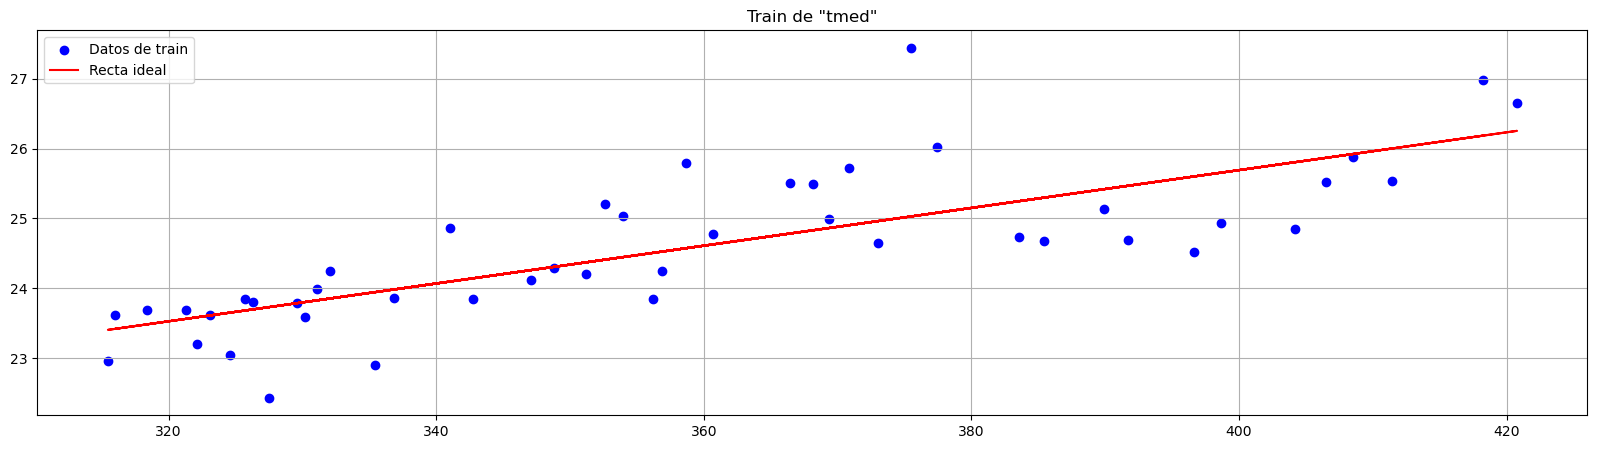

In [23]:
# Generamos un gráfico para comprobar la distribución de los datos de train (puntos) y nuestra predicción (línea)
plt.figure(figsize = (20, 5))
plt.scatter(X_train, y_train, color = 'blue', label = 'Datos de train')
plt.plot(X_train, regression_lineal.predict(X_train), color = 'red', label = 'Recta ideal')
plt.title('Train de "tmed"')
plt.grid()
plt.legend()
plt.show()

Teniendo en cuenta que el modelo de regresión lineal es un modelo que simplica a una recta la distribución de valores, encontramos que el modelo capta bien la distribución en los datos de train.

***Visualizamos los resultados de test***

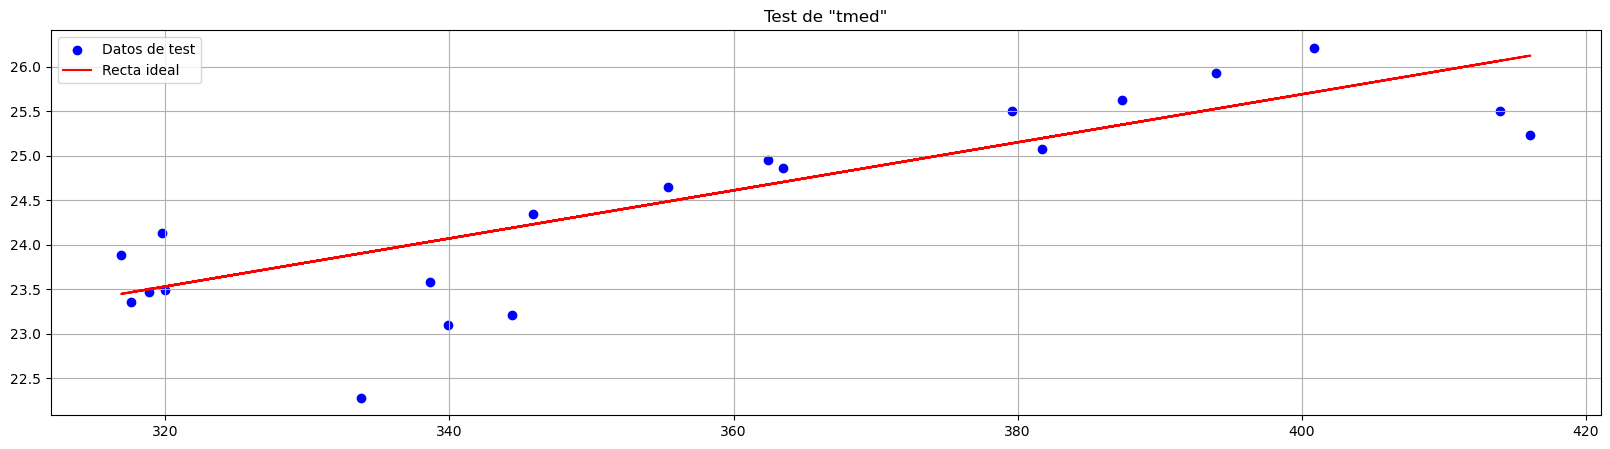

In [24]:
# Generamos un gráfico para comprobar la distribución de los datos de test (puntos) y nuestra predicción (línea)
plt.figure(figsize = (20, 5))
plt.scatter(X_test, y_test, color = 'blue', label = 'Datos de test')
plt.plot(X_test, regression_lineal.predict(X_test), color = 'red', label = 'Recta ideal' )
plt.title('Test de "tmed"')
plt.grid()
plt.legend()
plt.show()

Para el caso de test nuestro modelo de regresión lienal tiene encuentra una recta que explica la mayoría de los puntos pero se encuentra algunos valores atípicos por debajo de la recta.

***Visualizamos los errores***

Vamos a comprobar por cuánto ha errado nuestro modelo en cada punto. Para ello creamos una columna que mida la diferencia entre el valor real y la predicción de nuestro modelo.

In [25]:
# Creamos una variable 'diff' que mida la desviación entre los datos de test y las predicciones
errors = pd.DataFrame([y_test, y_test_predict, y_test-y_test_predict]).T
errors.columns = 'y_test', 'y_pred', 'diff'
errors.tail()

,y_test,y_pred,diff
15,24.859783,24.705074,0.154708
16,24.350000,24.228805,0.121195
17,24.955435,24.675568,0.279867
18,24.132609,23.524733,0.607876
19,23.095652,24.068017,-0.972364


In [26]:
# Biblioteca para calcular el intervalo de confianza
from scipy import stats

Mediante la variable 'target_year' se puede modificar el año hasta el que se quiere realizar la predicción.

In [27]:
# Selección del año objetivo
target_year = 2100

# Cálculo de años que faltan hasta 'target_year' para generar el gráfico
t_y = target_year - 2024 

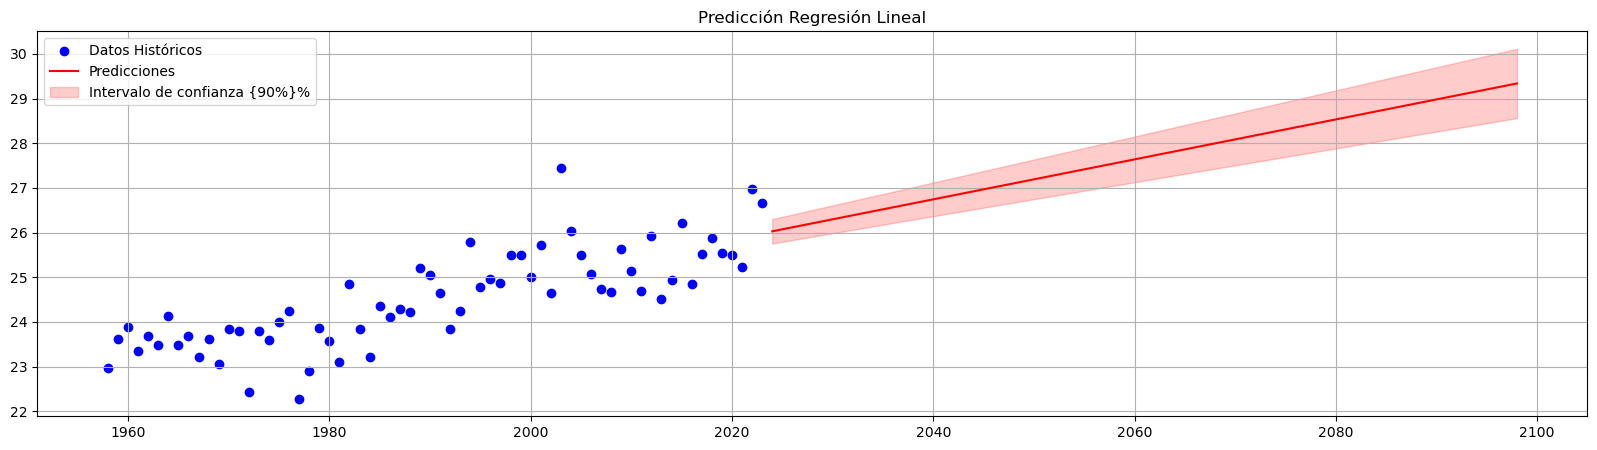

In [28]:
# Generamos una columna con los años del índice
df['year'] = df.index.year

# Seleccionamos las variables del modelo
X = df['year'].values.reshape(-1, 1)
y = df['tmed'].values

# Ajustamos el modelo de regrsión lineal
model = LinearRegression()
model.fit(X, y)

# Generamos fechas futuras y realizamos predicciones sobre ellas
future_years = np.arange(df['year'].max() + 1, df['year'].max() + t_y).reshape(-1, 1)
future_pred = model.predict(future_years)

# Calculamos el intervalo de confianza sobre la predicción y los almacenamos
predic, lower_interval, upper_interval = [], [], []
sum_squared_residuals = np.sum((y - model.predict(X)) ** 2)
n = len(y)
p_var = sum_squared_residuals / (n - 2)

# Obtenemos el valor de la distribución de t-Student superior e inferior.
# En este caso 0.95 corresponde al 90%, 5% por cada lado.
t_value = stats.t.ppf(0.95, df=n-2)

# Generamos un bucle para calcular el intervalo de confianza en cada año
for year in future_years.flatten():
    p = model.predict([[year]])[0]
    predic.append(p)
    
    interval_size = t_value * np.sqrt(p_var) * np.sqrt(1/n + (year - np.mean(X))**2 / np.sum((X - np.mean(X))**2))
    lower_interval.append(p - interval_size)
    upper_interval.append(p + interval_size)

# Generamos la gráfica
plt.figure(figsize=(20, 5))
plt.scatter(X, y, color = 'blue', label = 'Datos Históricos')
plt.plot(future_years, predic, color = 'red', label = 'Predicciones')
plt.fill_between(future_years.flatten(), lower_interval, upper_interval, color = 'red', alpha = 0.2, label = 'Intervalo de confianza {90%}%')
plt.title('Predicción Regresión Lineal')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Eliminamos la columna 'year' generada para la predicción de la gráfica anterior
df = df.drop(columns=['year'])

### c) II. Regresión Lineal Múltiple

Este tipo de modelo de regresión es capaz de captar la relación entre varias variables independientes para predecir la variable dependiente.

Somos conscientes de que no sabemos cómo van a evolucionar las distintas variables de antemano. Pero observemos cómo capta las relaciones y cómo explica el modelo de regresión lineal múltiple, con una temporalidad trimestral que se asemeja a la de las estaciones del año, la variable objetivo.

Eliminamos todas las variables que se refieran a las temperaturas de la selección de variables dependientes por motivos obvios.

In [30]:
# Seleccionamos las variables
X = df.drop(['tmed', 'tmin', 'tmax'], axis = 1)
y = df['tmed']
print(X.shape, y.shape)

(66, 5) (66,)


In [31]:
# Devidimos 'df' en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)
print(f'''Tamaño de los conjuntos de train y test:
- Train de X {X_train.shape}
- Test de X {X_test.shape}
- Train de y {y_train.shape}
- Test de y {y_test.shape}''')

Tamaño de los conjuntos de train y test:
- Train de X (46, 5)
- Test de X (20, 5)
- Train de y (46,)
- Test de y (20,)


In [32]:
# Convertimos el array a DataFrame para la selección de variables explicativas
X_train_df = pd.DataFrame(X_train, columns = X.columns)
X_test_df = pd.DataFrame(X_test, columns = X.columns)

In [33]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

Vamos a seleccionar las variables por el método 'forward', iniciando con la variable que mejor explique el modelo y añadiendo variables.

In [34]:
# Creamos un DataFrame vacío para almacenar los resultados en cada iteración
select = pd.DataFrame()

# Generamos un bucle para que seleccione las variables explicativas más relevantes, de una en adelante
for i in range(1, len(X_train_df.columns)):
    sbs = SFS(LinearRegression(), k_features = i,forward = True, floating = False)
    sbs.fit(np.array(X_train), y_train)
    sbs.k_feature_names_

    # Entrenamos el modelo con las variables seleccionada/as
    regression = LinearRegression()
    regression.fit(X_train_df[[X_train_df.columns[int(index)] for index in list(sbs.k_feature_idx_)]],
                   y_train)

    # Probamos el modelo entrenado en el conjunto de test y calculamos R2
    y_pred = regression.predict(X_test_df[[X_train_df.columns[int(index)]
                                           for index in list(sbs.k_feature_idx_)]])
    r2 = r2_score(y_pred = y_pred, y_true = y_test)

    #Almacenamos los resultados en ; DataFrame generado 'select'
    select = pd.concat([select,pd.DataFrame({
        "variables":[[X_train_df.columns[int(index)] for index in list(sbs.k_feature_idx_)]],
        "r2": r2})],ignore_index = True)

Comprobamos qué variables explican mejor el modelo:

In [35]:
# Ordenamos por mejor resultado en R2 la selección de variables del DataFrame 'selec'
select.sort_values(by = "r2", ascending = False, ignore_index = True)

,variables,r2
0,[co2],0.682480
1,"[sol, co2]",0.505942
2,"[sol, presMax, presMin, co2]",0.505284
3,"[sol, presMin, co2]",0.465410


En esta caso, más especial, nuestro modelo cree que el mejor modelo para explicar a la variable objetivo se consigue mediante la variable 'co2', solo una variable.

 - ***Observación***

Estamos realizando la selcción de variables de forma trimestral en este modelo de ***RLM***. Mientras que en los modelos con temporalidad anual la variable explicativa más relevante era 'co2', observamos que al pasar a una temporalidad más 'cortoplacista' la variable 'co2' pasa a ser irrelevante.

Esa es una apreciación lógica debido a que las temperaturas instantáneas son generadas por las presiones, por el sol, el viento, la humedad... Pero, al visualizar los datos a largo plazo comprobamos como la variable 'co2', causante del efecto invernadero, tiene mayor relevancia en la explicación de la temperatura.

In [36]:
# Seleccionamos las variables que mejor explican nuestra variable objetivo
X = df[select.sort_values(by = "r2", ascending = False, ignore_index = True)["variables"][0]]
y = df['tmed']

Volvemo a dividir el modelo en train y test ya que difiere con el anterior al haber realizado una selección de variables más óptimo.

In [37]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)

In [38]:
# Generamos el modelo de regresión múltiple
regression_mult = LinearRegression()
# Entrenamos con los datos de train
regression_mult.fit(X_train, y_train)

LinearRegression()

In [39]:
# Evaluamos el rendimiento de train
y_train_predict = regression_mult.predict(X_train)
rmse_m = mean_squared_error(y_train, y_train_predict, squared = False)
r2_m = r2_score(y_train, y_train_predict)

print(f'''Rendimiento del modelo para el conjunto de train
- R2: {r2_m}
- RMSE: {rmse_m}
''')

# Evaluamos el rendimiento de test
y_test_predict = regression_mult.predict(X_test)
rmse_m = mean_squared_error(y_test, y_test_predict, squared = False)
r2_m = r2_score(y_test, y_test_predict)

print(f'''Rendimiento del modelo para el conjunto de train
- R2: {r2_m}
- RMSE {rmse_m}
''')

Rendimiento del modelo para el conjunto de train
- R2: 0.6005416800080114
- RMSE: 0.6766027663752924

Rendimiento del modelo para el conjunto de train
- R2: 0.6824797583096394
- RMSE 0.6002427396360619



Comprobamos, como es lógico al utilizar la misma variable que en el modelo de regresión lineal simple, que el modelo de regresión lineal múltiple obtiene los mismos resultados que el modelo de regresión lineal simple.

Entendemos que las temperaturas altas son más difíciles de explicar que las bajas mediante los modelos de regresión lineal debido a nuestros resultados.

Aunqie en este caso estamos estudiando las temperaturas medias de los meses más calurosos.

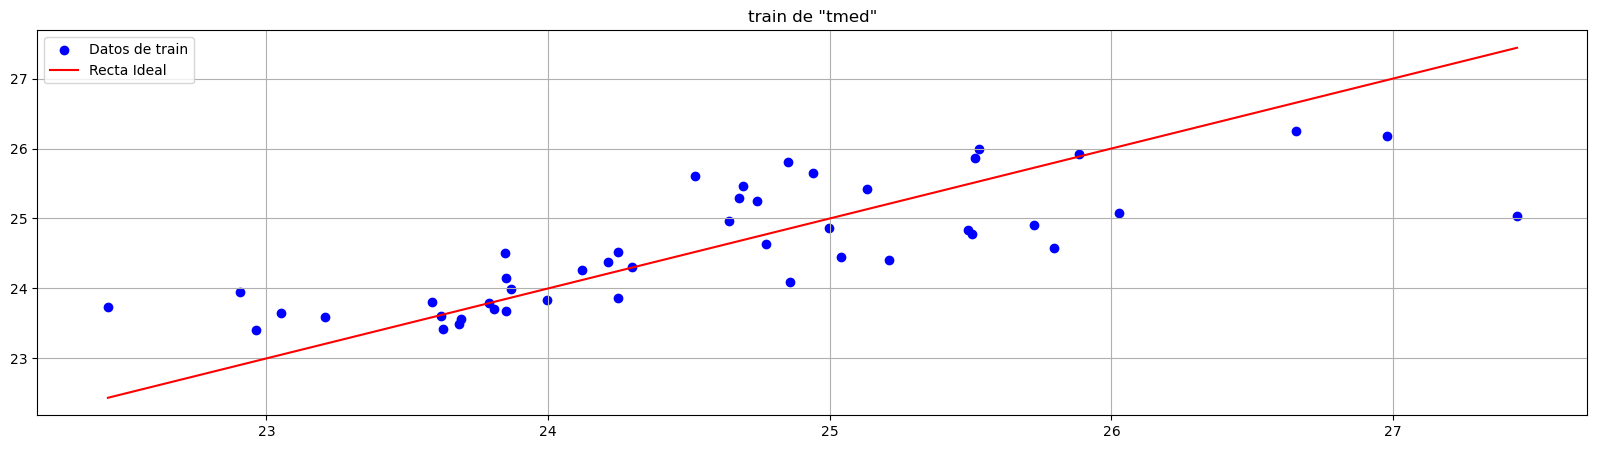

In [40]:
# Representación gráfica para el conjunto de entrenamiento
plt.figure(figsize = (20, 5))
plt.scatter(y_train, y_train_predict, color = 'blue', label = 'Datos de train')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color = 'red', label = 'Recta Ideal')
plt.title('train de "tmed"')
plt.grid()
plt.legend()
plt.show()

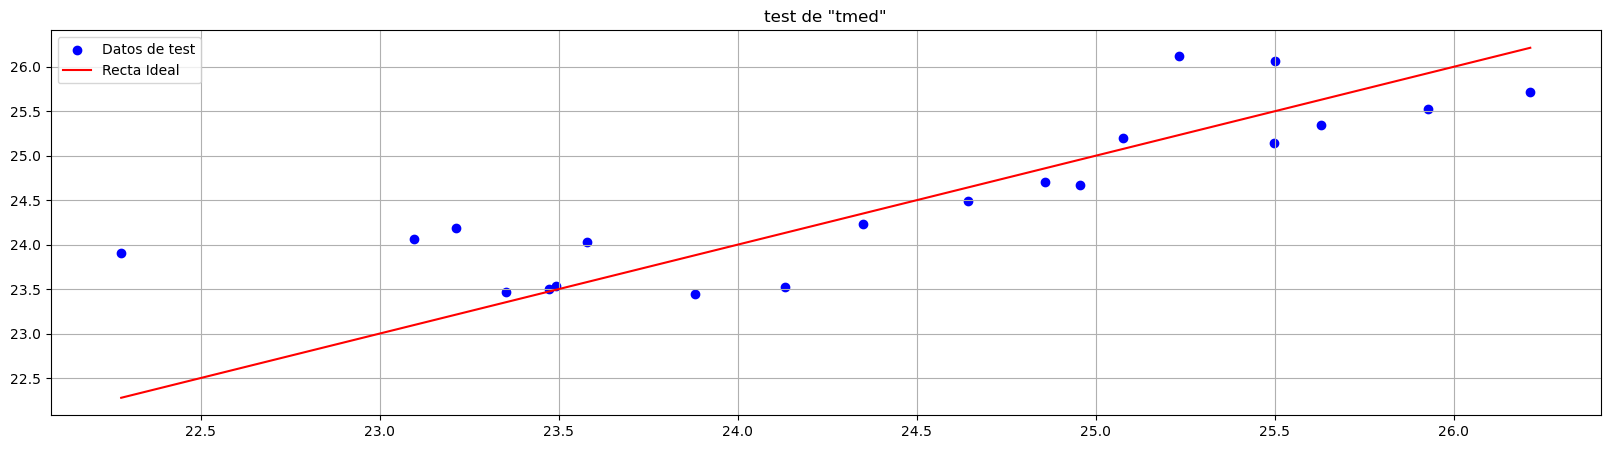

In [41]:
# Representación gráfica para el conjunto de prueba
plt.figure(figsize = (20, 5))
plt.scatter(y_test, y_test_predict, color = 'blue', label = 'Datos de test')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'red', label = 'Recta Ideal')
plt.title('test de "tmed"')
plt.grid()
plt.legend()
plt.show()

Comprobamos que la regresión lineal múltiple explica muy bien la variable objetivo. El motivo es que se ayuda del

### c) III. Regresión Polinómica

La regresión polinómica es una regresión lineal que ajusta los datos a una curva polinómica, al contrario que la lineal que la ajustaba a una recta.

En este tipo de modelos la selección del grado del polinomio es muy importante, puesto que un grado bajo no capturará la complejidad de los datos y un grado demasiado alto puede provocar sobreajuste.

Por este motivo definiremos una función para poder seleccionar el grado del polinomio y realizar pruebas de una forma ágil.

In [42]:
from sklearn.preprocessing import PolynomialFeatures

In [43]:
# Selecconasmo las variables
X = df[['co2']].values
y = df['tmed'].values
print(X.shape, y.shape)

(66, 1) (66,)


In [44]:
# Devidimos el dataset en train y test, dejando en test un tercio de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(46, 1) (20, 1) (46,) (20,)


***Ajustar la regresión polinómica con el dataset***

Generamos una función en la que podamos pasarle los grados del polinomio y realice los cálculos de forma automática.

In [45]:
def polynomial_regresion(X_test, X_train, degree):
    poly_features = PolynomialFeatures(degree = degree)
    X_train_poly = poly_features.fit_transform(X_train)
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
    
    y_train_predict = poly_model.predict(X_train_poly)
    r2_pol = r2_score(y_train, y_train_predict)
    rmse_pol = mean_squared_error(y_train, y_train_predict, squared = False)

    print(f'''Rendimiento del modelo para el conjunto de train
    R2: {r2_pol}
    RMSE: {rmse_pol}
    ''')

    y_test_predict = poly_model.predict(poly_features.transform(X_test))
    r2_pol = r2_score(y_test, y_test_predict)
    rmse_pol = mean_squared_error(y_test, y_test_predict, squared = False)

    print(f'''Rendimiento del modelo para el conjunto de test
    R2: {r2_pol}
    RMSE: {rmse_pol}
    ''')
    
    return y_train_predict, y_test_predict

In [46]:
y_train_pred, y_test_pred = polynomial_regresion(X_test, X_train, 3)

Rendimiento del modelo para el conjunto de train
    R2: 0.6309276447772381
    RMSE: 0.6503599540223632
    
Rendimiento del modelo para el conjunto de test
    R2: 0.5644406660559041
    RMSE: 0.7030154506784294
    


Parece ser que el modelo se ajusta bien sin sobreajestar con un grado 3. LLegamos a esta conclusión al comprobar que se reduce los datos en R2 para el conjunto de test. Esto nos indica que el modelo puede explicar menos los datos que no conoce.

Debemos tener en cuenta el problema que tenemos por el tamaño de la muestra, lo que también puede influir.

### Visualización de los resultados del Modelo Lineal Polinómico

#### Train

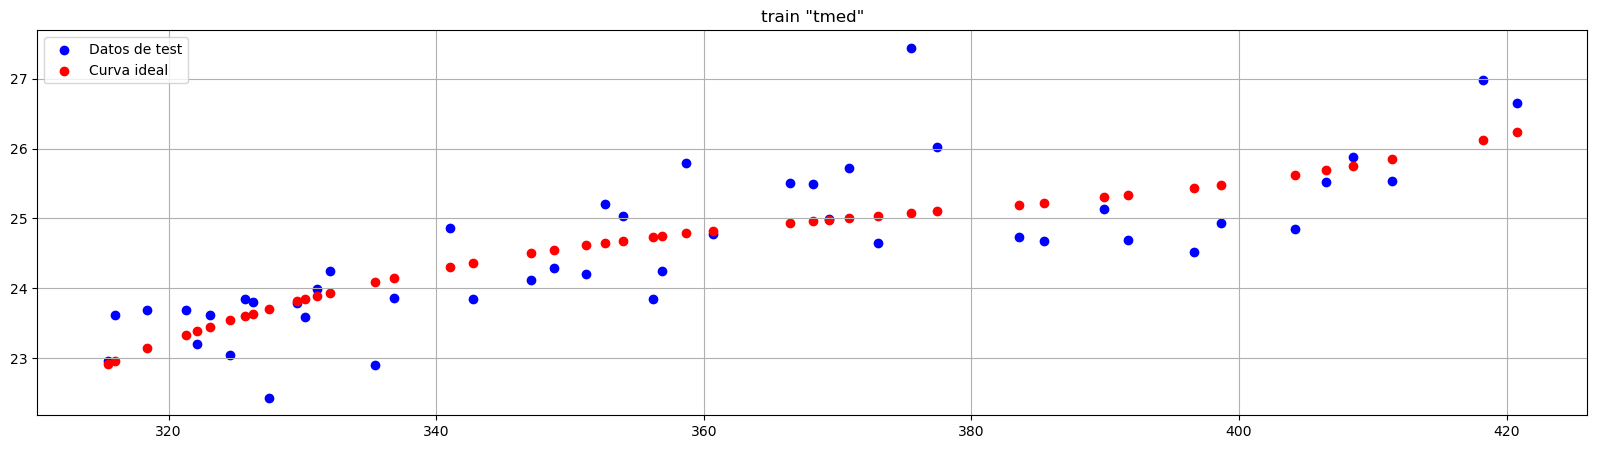

In [47]:
plt.figure(figsize = (20, 5))
plt.scatter(X_train, y_train, color = 'blue', label = 'Datos de test')
plt.scatter(X_train, y_train_pred, color = 'red', label = 'Curva ideal')
plt.title('train "tmed"')
plt.legend()
plt.grid()
plt.show()

#### Test

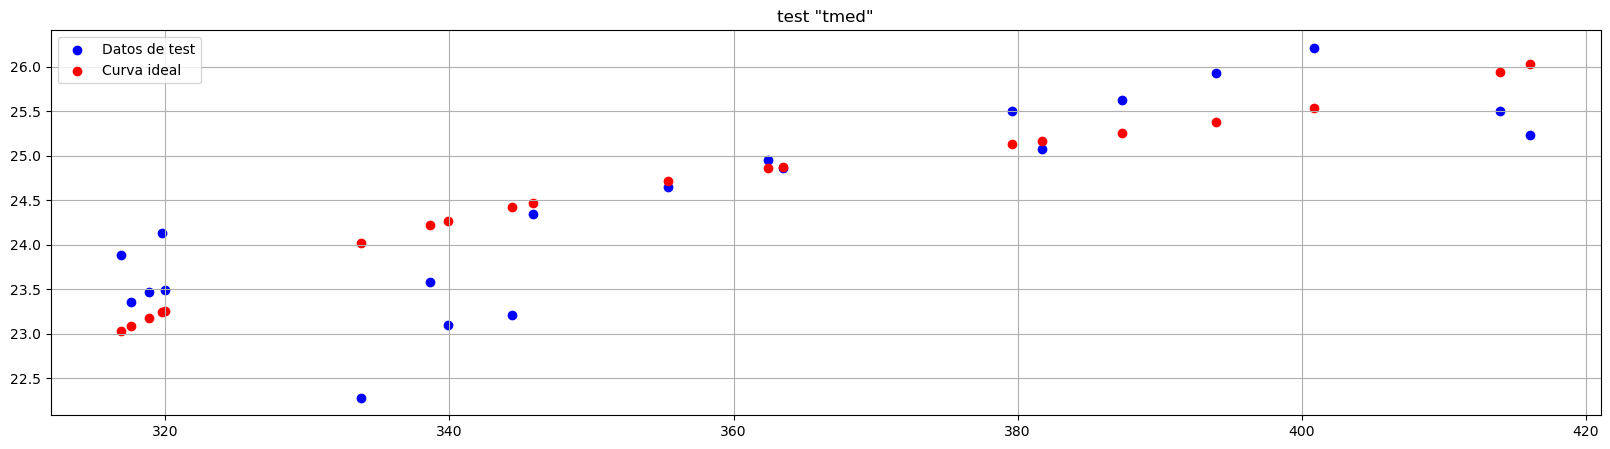

In [48]:
plt.figure(figsize=(20, 5))
plt.scatter(X_test, y_test,  color = 'blue', label = 'Datos de test')
plt.scatter(X_test, y_test_pred, color = 'red', label = 'Curva ideal')
plt.title('test "tmed"')
plt.legend()
plt.grid()
plt.show()

# e) Selección del modelo de regresión

El propósito de esta libreta es seleccionar el mejor modelo de regresión para la predicción de las temperaturas en el largo plazo. 

Entendemos qué, en el largo plazo el fenómeno que mayor influencia tiene sobre la temperatura es el dióxido de carbono (CO2). Por este motivo, el modelo seleccionado para la valoración de temperaturas futuras a largo plazo es el modelo de regresión lineal.

De este modo podremos predecir las temperaturas ayudándonos de las predicciones realizadas y guardadas en un fichero llamado 'co_future.csv', fichero que guarda las predicciones hasta el año 2100 de las cantidades de CO2 en la atmósfera.

En una sola celda ejecutamos todo el código necesario para la predicción de 'tmed'

In [49]:
# Importamos librería para guardar objetos
from joblib import dump

In [50]:
# Importamos los datos
df = pd.read_csv('valencia_clean.csv')
co = pd.read_csv('C:/Users/34610/Desktop/TFM/CO2/valencia_co2.csv')

# Pasamos a formato fecha la columna 'fecha'
df['fecha'] = pd.to_datetime(df['fecha'])
co['fecha'] = pd.to_datetime(co['fecha'])

# Seleccionamos la columna 'fecha' como índice
df = df.set_index('fecha', drop = True)
co = co.set_index('fecha', drop = True)

# Eliminamos las fechas posteriores a 1958 en 'df'
df = df[df.index > '1957-12-31']

# Cambiamos la temporalidad a anual mediante la media por año
co = co.resample('A').mean()

# Seleccionamos los meses de mayores temperaturas
df = df[df.index.month.isin([6, 7, 8])]

# Cambiamos la temporalidad a anual mediante la media por año
df = df.resample('A').mean()

# Unimos la columna 'co2' del DataFrame 'co' a DataFrame 'df'
df = df.join(co['co2'])

# Seleccionamos las variables
X = df[['co2']].values
y = df['tmed'].values

# Devidimos 'df' en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)

# Generamos el modelo de regresión lineal
regression_lineal = LinearRegression()
# Entrenamiento con datos de train
regression_lineal.fit(X_train, y_train)

# Guardamos el modelo de regresión lineal entrenado en un archivo
dump(regression_lineal, 'C:/Users/34610/Desktop/TFM/dispositivos_clean/valencia/modelos/valencia_verano_rgl_tmed.joblib')

['C:/Users/34610/Desktop/TFM/dispositivos_clean/valencia/modelos/valencia_verano_rgl_tmed.joblib']

Cargamos los datos de la predicción de la evolución del CO2 que realizamos en la libreta 'co2_prediction'. En esta libreta generamos una predicción de la evolución del CO2 hasta el año 2100.

In [51]:
# Importamos función load
from joblib import load

In [52]:
# Cargamos el DataFrame que guarda la predicción del CO2.
co_f = pd.read_csv('C:/Users/34610/Desktop/TFM/CO2/co_future.csv')

# Cargamos nuestro modelo de regresión lineal
model = load('C:/Users/34610/Desktop/TFM/dispositivos_clean/valencia/modelos/valencia_verano_rgl_tmed.joblib')

In [53]:
# Pasamos la columna 'fecha' a formato fecha
co_f['fecha'] = pd.to_datetime(co_f['fecha'])

# Seleccionamos la columna 'fecha' como índice
co_f = co_f.set_index('fecha', drop = True)

# Cambiamos la temporalidad de los datos a tipo anual
co_f = co_f.resample('A').mean()

Ahora seleccionamos la variable predicha a futuro 'co2' y realizamos las predicciones con nuestro modelo entrenado de regresión lineal.

In [54]:
# Seleccionamos la columna 'co2' del DataFrame 'co_f'
X_f = co_f[['co2']].values

# Con el modelo cargado de regresión lineal realizamos las predicciones
y_f_pred = model.predict(X_f)

# Guardamos las predicciones en un DataFrame para su visualización
tmed_f = pd.DataFrame({
    'tmed': y_f_pred
}, index=co_f.index)

# Renombramos el índice
tmed_f.indexname = 'fecha'

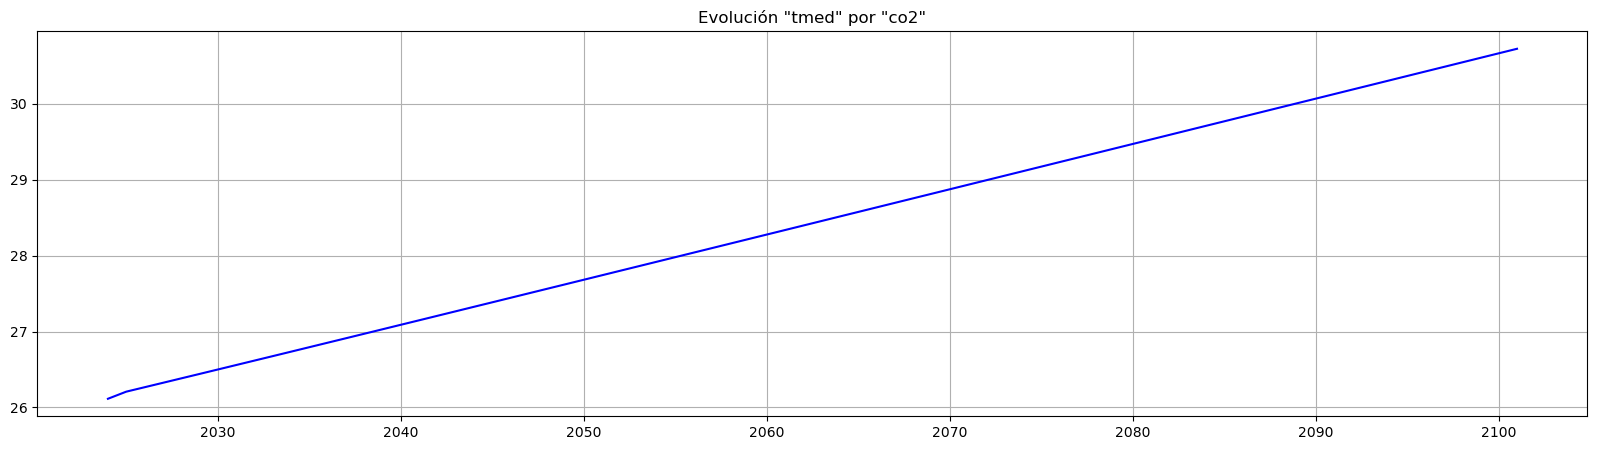

In [55]:
# Visualizamos la evolución de las temperaturas
plt.figure(figsize = (20, 5))
plt.plot(tmed_f.index, tmed_f['tmed'], color = 'blue')
plt.title('Evolución "tmed" por "co2"')
plt.grid()
plt.show()

Realizamos una pequeña comprobación:

In [56]:
# Cambio de 'tmed' en 'df' y 'tmed_future'
df_tmed_diff = df.tmed.max() - df.tmed.min()
tmed_f_diff = tmed_f.tmed.max() - df.tmed.max()

print(f'''
La temperatura media en los meses más calurosos:
- En {df.shape[0]} años ha subido {round(df_tmed_diff, 2)} grados, una media de {round((df_tmed_diff/df.shape[0]), 2)} grados al año.
- El modelo que hemos creado prevé que las temperaturas suban {round(tmed_f_diff, 2)} grados en {tmed_f.shape[0]}, una media de {round((tmed_f_diff/tmed_f.shape[0]), 2)} grados al año.
- Se prevé que para el año 2100 la temperatura sea de {round(tmed_f.tmed.max(), 2)} frente a la media de {round(df['tmed'].iloc[-1], 2)} grados actuales
''')


La temperatura media en los meses más calurosos:
- En 66 años ha subido 5.16 grados, una media de 0.08 grados al año.
- El modelo que hemos creado prevé que las temperaturas suban 3.28 grados en 78, una media de 0.04 grados al año.
- Se prevé que para el año 2100 la temperatura sea de 30.73 frente a la media de 26.66 grados actuales



In [57]:
tmed_f.to_csv('escenarios_futuros/valencia_verano_tmed_future.csv')

Observamos que nuestra predicción evoluciona de una forma similar a la que hemos observado en nuestro datos.

Podemos concluir que si continuamos aumentando la cantidad de CO2 a la atmósfera aumentaremos la temperatura para el año 2100 en los grados indicados.

Esperamos que este estudio sirva para prevenir de posibles futuros escenarios.

### Generamos la predicción para las temperaturas máximas

La variable 'co2', que representa la cantidad de CO2, es la que mejor explica la evolución de las temperaturas en el largo plazo.

En el apartado b) de la libreta observamos que la variable con la que mejor correlaciona 'co2' es con la variable 'tmed'. Por este motivo hemos calculado la evolución de 'tmed' mediante 'co2'.

Ahora predeciremos la evolución de 'tmax' y 'tmin' mediante la predicción realizada para 'tmed'.

Para ello entrenaremos 'tmax' y 'tmin' con la variable 'tmed'

In [58]:
# Seleccionamos las variables
X = df[['tmed']].values
y = df['tmax'].values

# Devidimos 'df' en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)

# Generamos el modelo de regresión lineal
regression_lineal = LinearRegression()
# Entrenamiento con datos de train
regression_lineal.fit(X_train, y_train)

# Guardamos el modelo de regresión lineal entrenado en un archivo
dump(regression_lineal, 'C:/Users/34610/Desktop/TFM/dispositivos_clean/valencia/modelos/valencia_verano_rgl_tmax.joblib')

['C:/Users/34610/Desktop/TFM/dispositivos_clean/valencia/modelos/valencia_verano_rgl_tmax.joblib']

Cargamos los datos de la predicción de la evolución del CO2 que realizamos en la libreta 'co2_prediction'. En esta libreta generamos una predicción de la evolución del CO2 hasta el año 2100.

In [59]:
# Cargamos el DataFrame que guarda la predicción de 'tmed'.
tmed_verano_f = pd.read_csv('escenarios_futuros/valencia_verano_tmed_future.csv')

# Cargamos nuestro modelo de regresión lineal
model = load('C:/Users/34610/Desktop/TFM/dispositivos_clean/valencia/modelos/valencia_verano_rgl_tmax.joblib')

In [60]:
# Pasamos la columna 'fecha' a formato fecha
tmed_verano_f['fecha'] = pd.to_datetime(tmed_verano_f['fecha'])

# Seleccionamos la columna 'fecha' como índice
tmed_verano_f = tmed_verano_f.set_index('fecha', drop = True)

Ahora seleccionamos la variable predicha a futuro 'tmed' y realizamos las predicciones con nuestro modelo entrenado de regresión lineal.

In [61]:
# Seleccionamos la columna 'tmed' del DataFrame 'tmed_verano_f'
X_f = tmed_verano_f[['tmed']].values

# Con el modelo cargado de regresión lineal realizamos las predicciones
y_f_pred = model.predict(X_f)

# Guardamos las predicciones en un DataFrame para su visualización
tmax_f = pd.DataFrame({
    'tmax': y_f_pred
}, index=tmed_verano_f.index)

# Renombramos el índice
tmax_f.indexname = 'fecha'

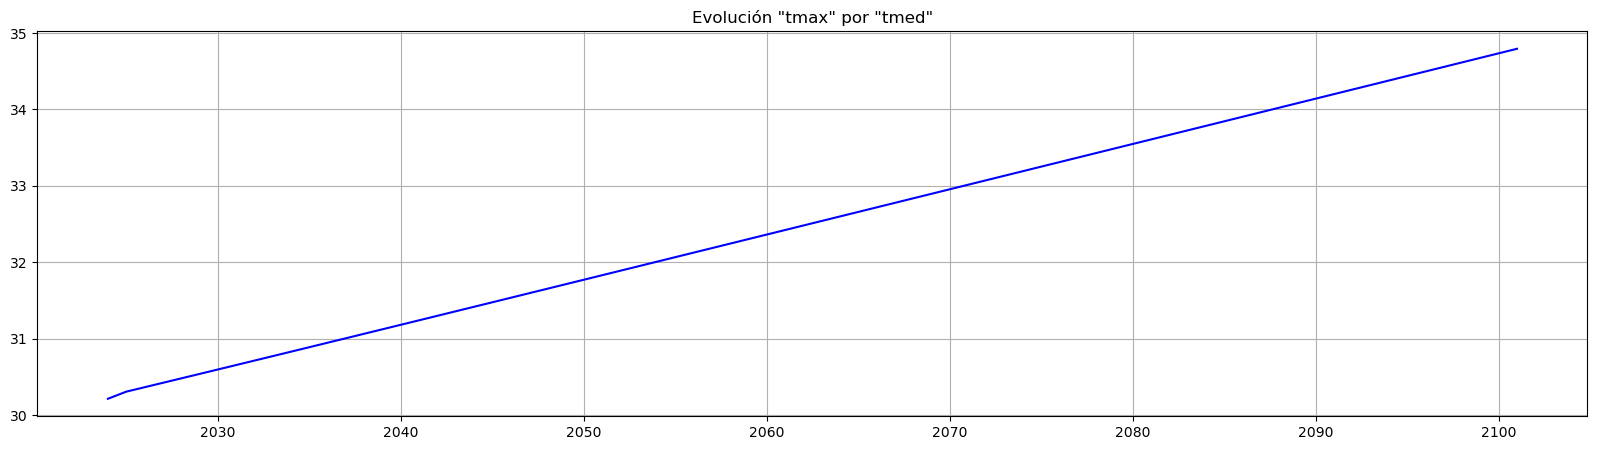

In [62]:
# Visualizamos la evolución de las temperaturas
plt.figure(figsize = (20, 5))
plt.plot(tmed_f.index, tmax_f['tmax'], color = 'blue')
plt.title('Evolución "tmax" por "tmed"')
plt.grid()
plt.show()

Realizamos una pequeña comprobación:

In [63]:
# Cambio de 'tmax' en 'df' y 'tmax_future'
df_tmax_diff = df.tmax.max() - df.tmax.min()
tmax_f_diff = tmax_f.tmax.max() - df.tmax.max()

print(f'''
La temperatura máxima media en los meses de mayor calor:
- En {df.shape[0]} años ha subido {round(df_tmax_diff, 2)} grados, una media de {round((df_tmax_diff/df.shape[0]), 2)} grados al año.
- El modelo que hemos creado prevé que las temperaturas suban {round(tmax_f_diff, 2)} grados en {tmax_f.shape[0]} años, una media de {round((tmax_f_diff/tmax_f.shape[0]), 2)} grados al año.
- Se prevé que para el año 2100 la temperatura sea de {round(tmax_f.tmax.max(), 2)} frente a la media de {round(df['tmax'].iloc[-1], 2)} grados actuales
''')


La temperatura máxima media en los meses de mayor calor:
- En 66 años ha subido 6.0 grados, una media de 0.09 grados al año.
- El modelo que hemos creado prevé que las temperaturas suban 2.79 grados en 78 años, una media de 0.04 grados al año.
- Se prevé que para el año 2100 la temperatura sea de 34.79 frente a la media de 30.34 grados actuales



### Generamos la predicción para las temperaturas mínimas

El procedimiento para la predición de 'tmin' será igual el utilizado para la predicción de 'tmax'. Por lo que se escribirá todo en una línea de código.

In [64]:
# Seleccionamos las variables
X = df[['tmed']].values
y = df['tmin'].values

# Devidimos 'df' en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)

# Generamos el modelo de regresión lineal
regression_lineal = LinearRegression()
# Entrenamiento con datos de train
regression_lineal.fit(X_train, y_train)

# Guardamos el modelo de regresión lineal entrenado en un archivo
dump(regression_lineal, 'C:/Users/34610/Desktop/TFM/dispositivos_clean/valencia/modelos/valencia_verano_rgl_tmin.joblib')

# Cargamos el DataFrame que guarda la predicción de 'tmed'.
tmed_verano_f = pd.read_csv('escenarios_futuros/valencia_verano_tmed_future.csv')

# Cargamos nuestro modelo de regresión lineal
model = load('C:/Users/34610/Desktop/TFM/dispositivos_clean/valencia/modelos/valencia_verano_rgl_tmin.joblib')

# Pasamos la columna 'fecha' a formato fecha
tmed_verano_f['fecha'] = pd.to_datetime(tmed_verano_f['fecha'])

# Seleccionamos la columna 'fecha' como índice
tmed_verano_f = tmed_verano_f.set_index('fecha', drop = True)

# Seleccionamos la columna 'tmed' del DataFrame 'tmed_verano_f'
X_f = tmed_verano_f[['tmed']].values

# Con el modelo cargado de regresión lineal realizamos las predicciones
y_f_pred = model.predict(X_f)

# Guardamos las predicciones en un DataFrame para su visualización
tmin_f = pd.DataFrame({
    'tmin': y_f_pred
}, index=tmed_verano_f.index)

# Renombramos el índice
tmin_f.indexname = 'fecha'

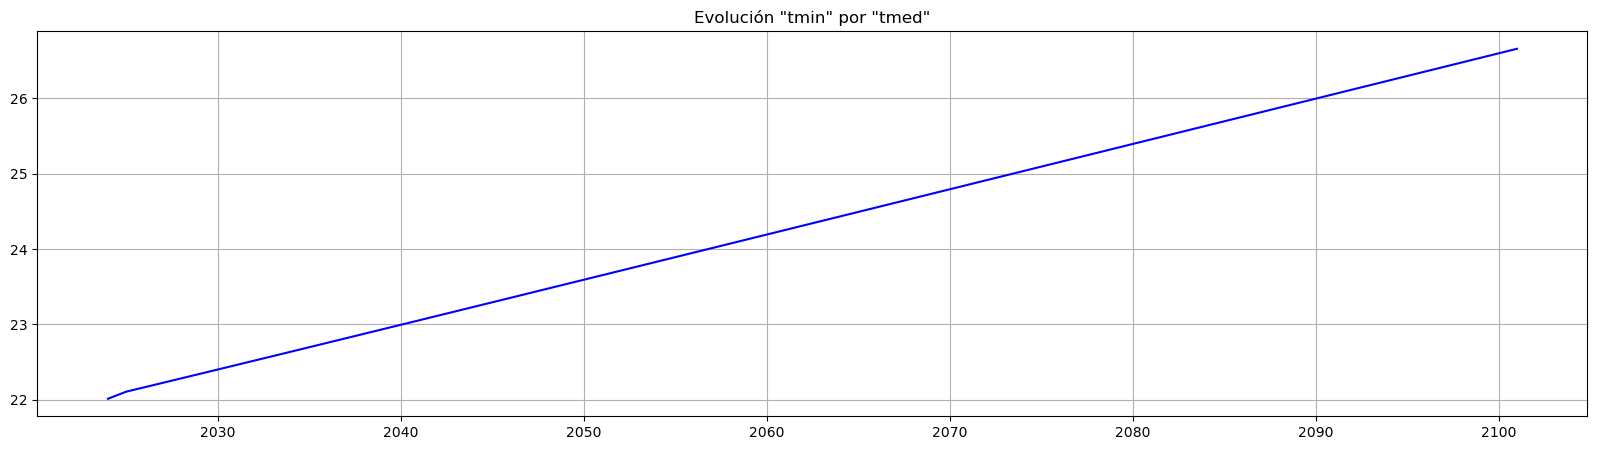

In [65]:
# Visualizamos la evolución de las temperaturas
plt.figure(figsize = (20, 5))
plt.plot(tmed_f.index, tmin_f['tmin'], color = 'blue')
plt.title('Evolución "tmin" por "tmed"')
plt.grid()
plt.show()

In [66]:
# Cambio de 'tmin' en 'df' y 'tmin_future'
df_tmin_diff = df.tmin.max() - df.tmin.min()
tmin_f_diff = tmin_f.tmin.max() - df.tmin.max()

print(f'''
La temperatura mínima media en los meses más calurosos:
- En {df.shape[0]} años ha subido {round(df_tmin_diff, 2)} grados, una media de {round((df_tmin_diff/df.shape[0]), 2)} grados al año.
- El modelo que hemos creado prevé que las temperaturas suban {round(tmin_f_diff, 2)} grados en {tmin_f.shape[0]}, una media de {round((tmin_f_diff/tmin_f.shape[0]), 2)} grados al año.
- Se prevé que para el año 2100 la temperatura sea de {round(tmin_f.tmin.max(), 2)} frente a la media de {round(df['tmin'].iloc[-1], 2)} grados actuales
''')


La temperatura mínima media en los meses más calurosos:
- En 66 años ha subido 4.86 grados, una media de 0.07 grados al año.
- El modelo que hemos creado prevé que las temperaturas suban 3.69 grados en 78, una media de 0.05 grados al año.
- Se prevé que para el año 2100 la temperatura sea de 26.66 frente a la media de 22.97 grados actuales



In [67]:
df_t_medias_pred = tmin_f.join(tmed_f, on = 'fecha')

In [68]:
df_t_medias_pred = df_t_medias_pred.join(tmax_f, on = 'fecha')

In [69]:
df_t_medias_pred = df_t_medias_pred.join(co_f, on = 'fecha')

La primera fecha del DataFrame 'df_t_medias_pred'coincide con la última del DataFrame 'df'. Por este motivo vamos a eliminar la primera fila de la predicción.

In [70]:
df_t_medias_pred = df_t_medias_pred.iloc[1:]

In [71]:
valencia_1958_2100 = df[['tmin', 'tmed', 'tmax', 'co2']]

In [72]:
valencia_1958_2100 = pd.concat([valencia_1958_2100, df_t_medias_pred])

In [73]:
valencia_1958_2100.to_csv('escenarios_futuros/valencia_verano_1958_2100_verano.csv')